# LeNet-5 на Keras

Пробуем воспроизвести первую работу [Яна ЛеКуна](http://yann.lecun.com/) по свёрточным сетям LeNet-5 на [Keras](http://keras.io/).

Опираемся на статью "[Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)" Y. LeCun, L. Bottou, Y.Bengio, and P.Haffner (1998).

В основном, получилось, кроме двух моментов:
* данные со свёрточных слоев (после реcамплинга) передаются к следующем сверточному слою 'один к одному' — а не через специальный слой-посредник с особой топологией соединений
* последний слой — не RBF (Radial Basis Function) функция активации

## Установленные пакеты

Для корректной работы надо установить:
#for pydot-ng

sudo apt-get install graphviz

pip3 install keras matplotlib nose nose-parameterized scikit-image pycuda graphviz pydot-ng

In [1]:
%matplotlib inline

import os, pickle, gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image

# pydot-ng work in Python 3
import pydot_ng as pydot

In [2]:
# Включаем использование GPU в Theano
os.environ['THEANO_FLAGS']='device=gpu,floatX=float32'

In [3]:
# загружаем Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot

Using Theano backend.
Using gpu device 0: GeForce GTX 760 (CNMeM is disabled, cuDNN 4007)


## Загружаем данные

In [4]:
# Они уже приготовлены и разделены на тренировочный и тестовый набор
f = gzip.open('mnist.pkl.gz', 'rb')
(X_train, y_train), (X_test, y_test) = pickle.load(f, encoding="bytes")
f.close()

In [5]:
X_train.shape

(60000, 32, 32)

In [6]:
# Преобразуем данные в формат для сверточной сети
images_size = 32
X_train = X_train.reshape(X_train.shape[0], 1, images_size, images_size)
X_test = X_test.reshape(X_test.shape[0], 1, images_size, images_size)

In [7]:
# Преобразуем целые числа от 0 до 255, кодирующее оттенки серого в картинке, в число 
# с плавающей точкой, в интервале от 0 до 1 
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [8]:
# Кодируем выходные данные в бинарный вектор размерностью 10, где только в 
# одной позиции стоит 1, остальные нули 
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

### Проверка

In [9]:
index = 242

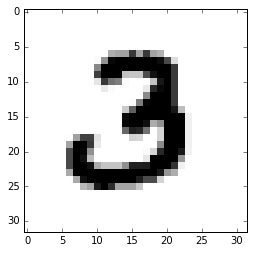

In [10]:
plt.imshow(X_train[index, 0], cmap=cm.gray_r, interpolation='nearest')

In [11]:
y_train[index]

3

In [12]:
Y_train[index]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

## Создаём модель

In [13]:
model = Sequential()

model.add(Convolution2D(6, 5, 5, input_shape = (1, 32, 32), name="C1"))

model.add(AveragePooling2D(pool_size=(2, 2), name="S2"))
model.add(Activation('tanh'))

model.add(Convolution2D(16, 5, 5, name="C3"))

model.add(AveragePooling2D(pool_size=(2, 2), name="S4"))
model.add(Activation('tanh'))

model.add(Convolution2D(120, 5, 5, name="C5"))

model.add(Flatten())
model.add(Dense(84, activation="tanh", name="F6"))

model.add(Dense(10, name="stab"))

### Отображаем модель и размеры слоёв

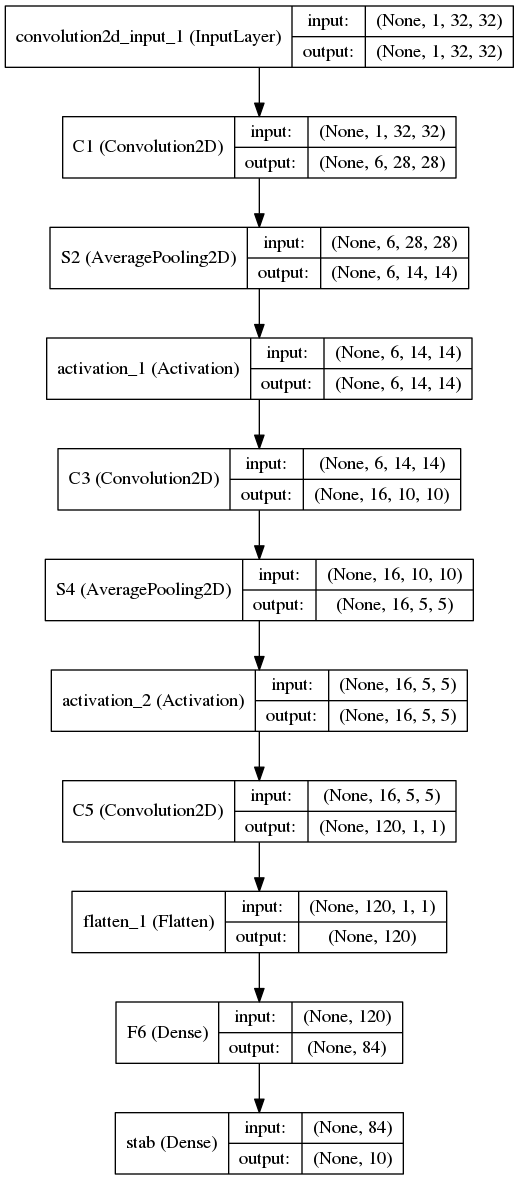

In [14]:
Image(model_to_dot(model, show_shapes=1).create_png())

### Обучаем модель

In [15]:
model.compile(loss='mean_squared_error', optimizer='Adam')

In [16]:
model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s - loss: 0.0379 - val_loss: 0.0214
Epoch 2/20
60000/60000 [==============================] - 4s - loss: 0.0187 - val_loss: 0.0155
Epoch 3/20
60000/60000 [==============================] - 4s - loss: 0.0150 - val_loss: 0.0137
Epoch 4/20
60000/60000 [==============================] - 4s - loss: 0.0127 - val_loss: 0.0114
Epoch 5/20
60000/60000 [==============================] - 4s - loss: 0.0107 - val_loss: 0.0099
Epoch 6/20
60000/60000 [==============================] - 4s - loss: 0.0092 - val_loss: 0.0083
Epoch 7/20
60000/60000 [==============================] - 5s - loss: 0.0078 - val_loss: 0.0068
Epoch 8/20
60000/60000 [==============================] - 4s - loss: 0.0067 - val_loss: 0.0062
Epoch 9/20
60000/60000 [==============================] - 5s - loss: 0.0059 - val_loss: 0.0058
Epoch 10/20
60000/60000 [==============================] - 5s - loss: 0.0053 - val_loss: 0.0055

In [17]:
predict = model.predict(X_test)

In [18]:
predict.shape

(10000, 10)

In [19]:
is_true = 0
for row_index in range(predict.shape[0]):
    predict_index = predict[row_index].argmax()
    true_index = Y_test[row_index].argmax()
    if true_index == predict_index:
        is_true += 1

In [20]:
is_true

9825

### Процент ошибок на тестовой выборки - 1.7%

In [21]:
(predict.shape[0] - is_true) / predict.shape[0] * 100

1.7500000000000002